# Home Credit Risk Prediction
**Final Project - Rakamin x Home Credit Indonesia**  
**Author:** Benedictus Briatore Ananta  
**Tanggal:** 26 Mei 2025

##  Usiness Context
Home Credit ingin meningkatkan akurasi sistem skor kredit agar pelanggan yang layak tidak ditolak, dan risiko gagal bayar bisa diminimalkan.

## Objective
Memprediksi apakah pemohon akan gagal bayar (`TARGET = 1`) atau tidak (`TARGET = 0`) menggunakan machine learning.

## Evaluation Metrics
- Accuracy  
- ROC-AUC  
- Confusion Matrix  
- Classification Report


In [41]:
# 1. Import Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.utils import resample

In [42]:
# 2. Load Dataset
app = pd.read_csv("application_train.csv")
print("Dataset shape:", app.shape)

Dataset shape: (307511, 122)


# EDA

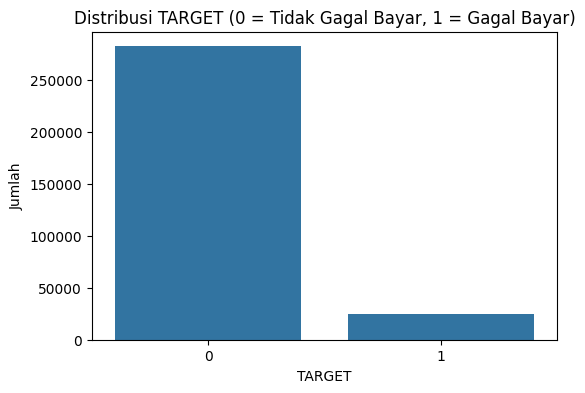

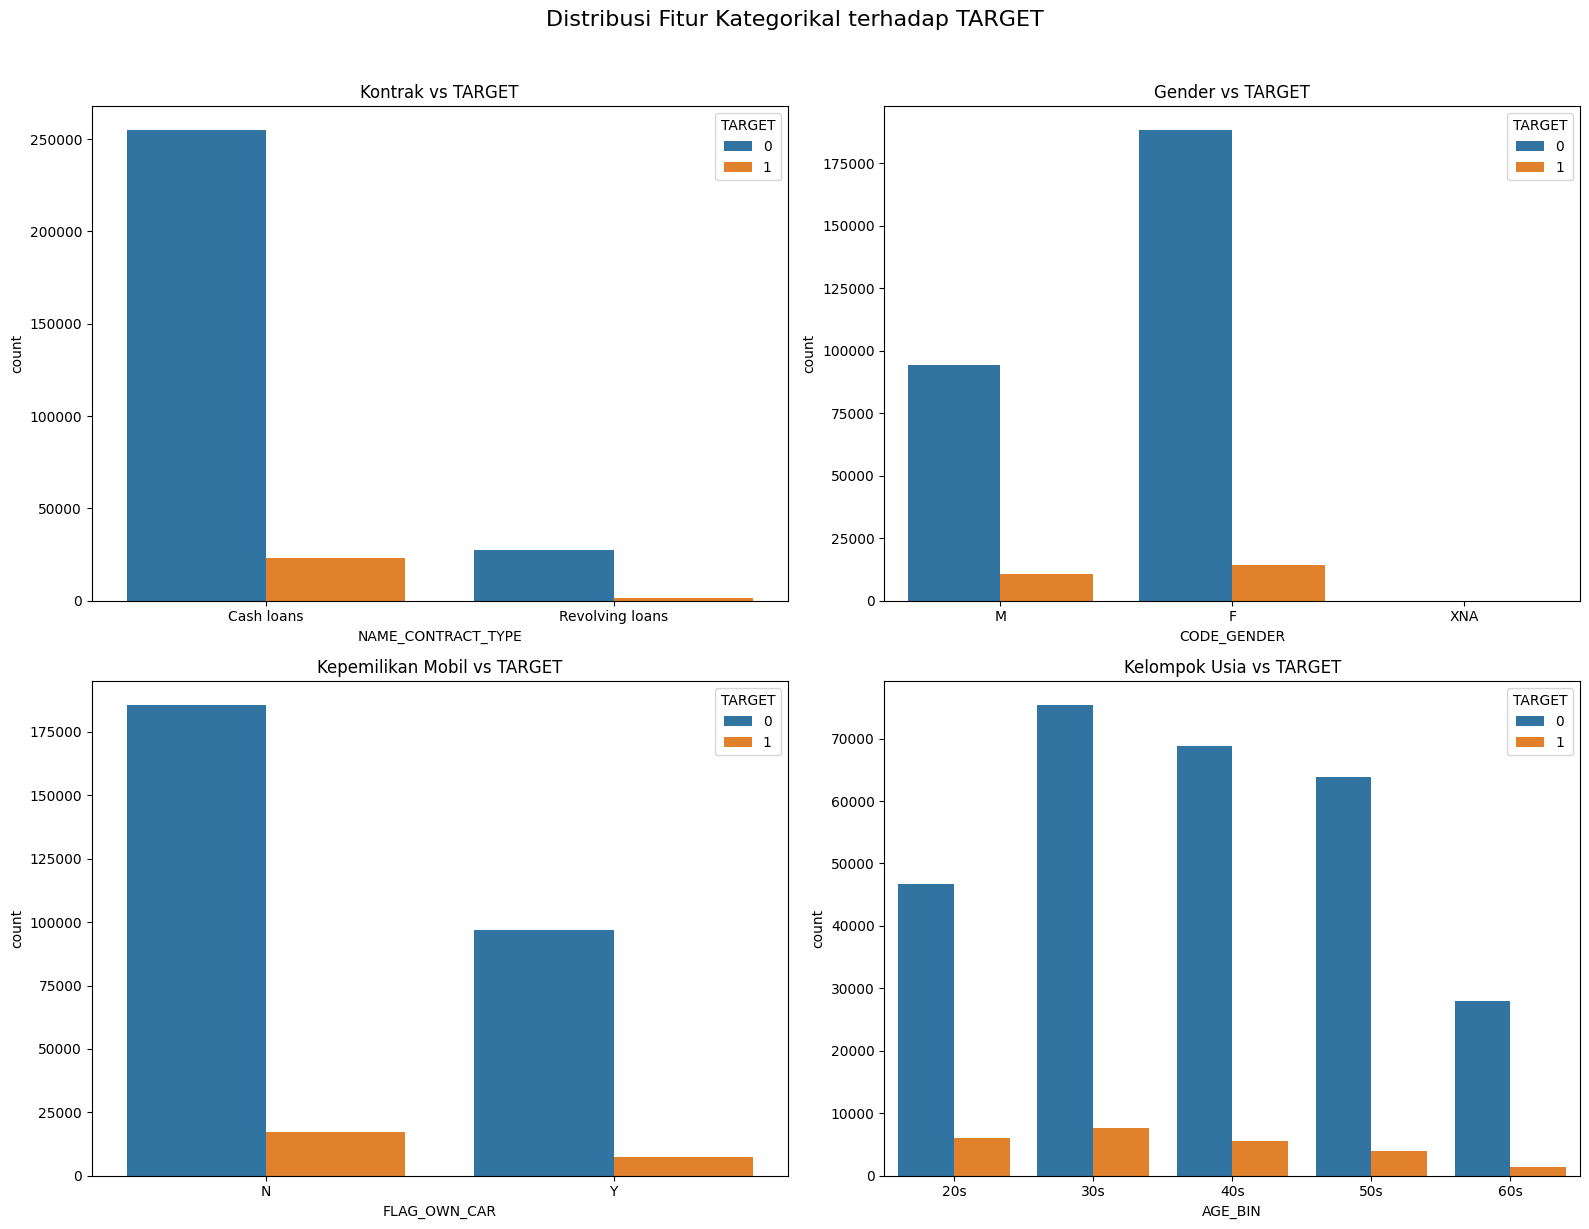

In [43]:
# 1. Pastikan kolom tidak memiliki NaN
app['DAYS_BIRTH'] = app['DAYS_BIRTH'].fillna(app['DAYS_BIRTH'].median())

# 2. Tambahkan kolom umur dan kategori umur
app['AGE'] = (-app['DAYS_BIRTH'] / 365).astype(int)
app['AGE_BIN'] = pd.cut(app['AGE'], bins=[20,30,40,50,60,70], labels=['20s','30s','40s','50s','60s'])

# 3. Visualisasi distribusi TARGET
plt.figure(figsize=(6,4))
sns.countplot(x='TARGET', data=app)
plt.title("Distribusi TARGET (0 = Tidak Gagal Bayar, 1 = Gagal Bayar)")
plt.xlabel("TARGET")
plt.ylabel("Jumlah")
plt.show()

# 4. Visualisasi fitur kategori terhadap TARGET dalam subplot
fig, ax = plt.subplots(2, 2, figsize=(16, 12))

sns.countplot(x='NAME_CONTRACT_TYPE', hue='TARGET', data=app, ax=ax[0][0])
ax[0][0].set_title("Kontrak vs TARGET")

sns.countplot(x='CODE_GENDER', hue='TARGET', data=app, ax=ax[0][1])
ax[0][1].set_title("Gender vs TARGET")

sns.countplot(x='FLAG_OWN_CAR', hue='TARGET', data=app, ax=ax[1][0])
ax[1][0].set_title("Kepemilikan Mobil vs TARGET")

sns.countplot(x='AGE_BIN', hue='TARGET', data=app, ax=ax[1][1])
ax[1][1].set_title("Kelompok Usia vs TARGET")

# Tambahan spacing & judul besar
fig.subplots_adjust(wspace=0.3, hspace=0.4)
plt.suptitle("Distribusi Fitur Kategorikal terhadap TARGET", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

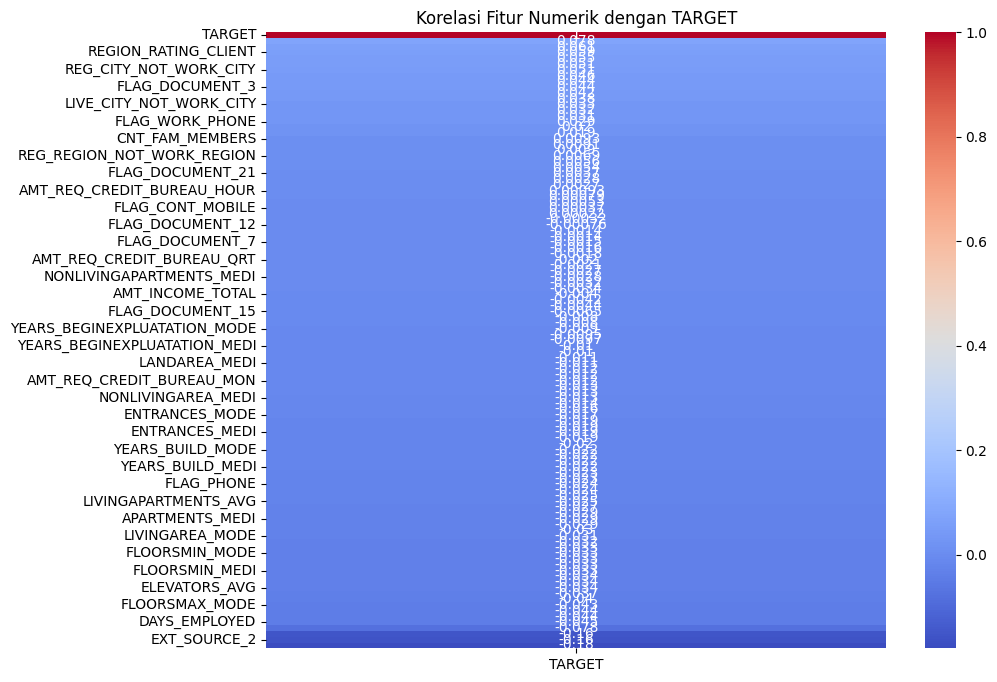

In [44]:
# Korelasi numerik dengan TARGET
num_cols = app.select_dtypes(include=np.number).columns
plt.figure(figsize=(10,8))
sns.heatmap(app[num_cols].corr()[['TARGET']].sort_values(by='TARGET', ascending=False), annot=True, cmap='coolwarm')
plt.title("Korelasi Fitur Numerik dengan TARGET")
plt.show()

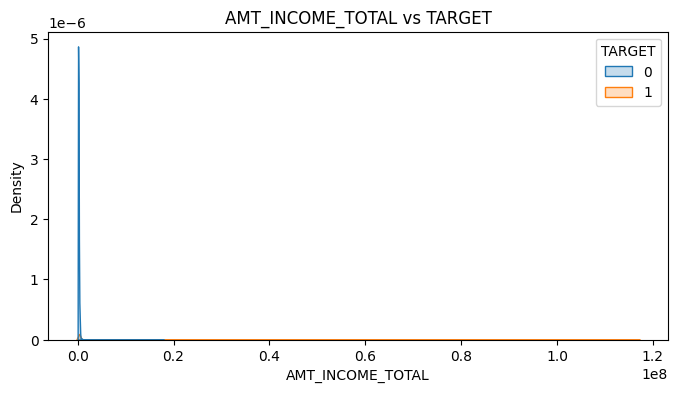

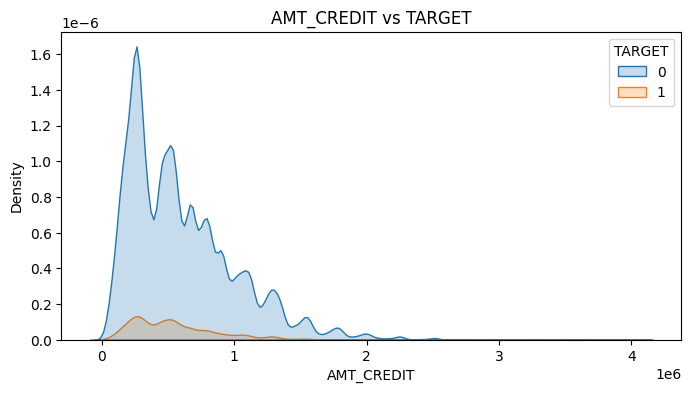

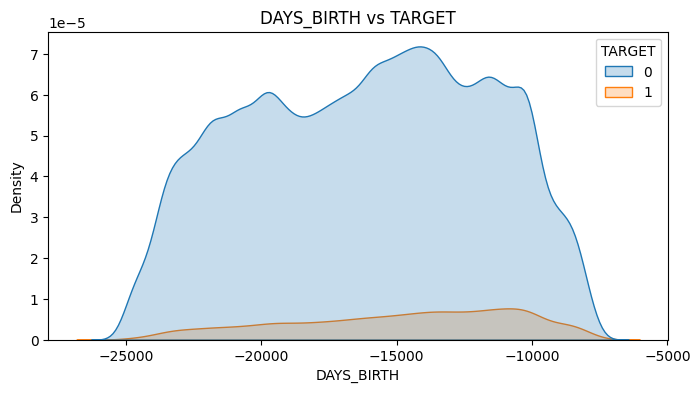

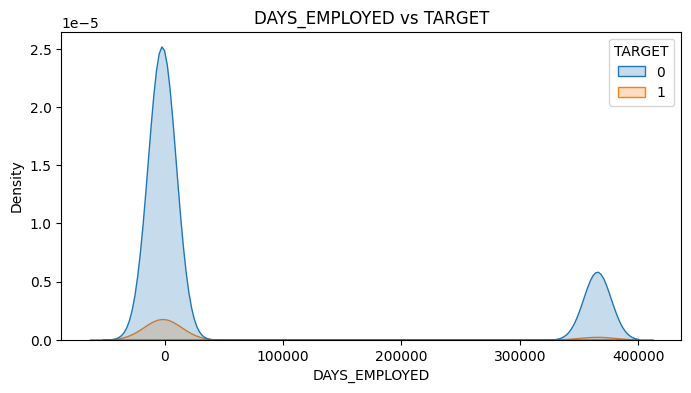

In [45]:
# KDE distribusi fitur numerik
numerical = ['AMT_INCOME_TOTAL', 'AMT_CREDIT', 'DAYS_BIRTH', 'DAYS_EMPLOYED']
for col in numerical:
    plt.figure(figsize=(8,4))
    sns.kdeplot(data=app, x=col, hue='TARGET', fill=True)
    plt.title(f"{col} vs TARGET")
    plt.show()

# Preprocessing

In [46]:
# Hapus kolom dengan >50% missing
app = app.loc[:, app.isnull().mean() < 0.5]

# Imputasi median untuk numerik
num_cols = app.select_dtypes(include=np.number).columns
app[num_cols] = app[num_cols].fillna(app[num_cols].median())

# Encode kategori
cat_cols = app.select_dtypes(include='object').columns
le = LabelEncoder()
for col in cat_cols:
    if app[col].nunique() <= 2:
        app[col] = le.fit_transform(app[col].astype(str))
    else:
        app = pd.get_dummies(app, columns=[col], drop_first=True)

# Feature Selection & Balancing

In [47]:
features = ['AMT_INCOME_TOTAL', 'AMT_CREDIT', 'DAYS_EMPLOYED', 'DAYS_BIRTH',
            'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']
features = [f for f in features if f in app.columns]

X = app[features]
y = app['TARGET']

# Undersampling
X_0 = app[app['TARGET'] == 0][features]
y_0 = app[app['TARGET'] == 0]['TARGET']
X_1 = app[app['TARGET'] == 1][features]
y_1 = app[app['TARGET'] == 1]['TARGET']
X_0_down, y_0_down = resample(X_0, y_0, replace=False, n_samples=len(y_1)*3, random_state=42)
X_bal = pd.concat([X_0_down, X_1])
y_bal = pd.concat([y_0_down, y_1])

# Modelling dan Evaluasi

In [48]:
# Split & Scale
X_train, X_test, y_train, y_test = train_test_split(X_bal, y_bal, test_size=0.2, stratify=y_bal, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [49]:
# Modeling & Evaluasi
models = {
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "KNN": KNeighborsClassifier(),
    "Naive Bayes": GaussianNB(),
    "MLP": MLPClassifier(max_iter=300)
}

def evaluate_model(name, model):
    model.fit(X_train_scaled, y_train)
    for label, X_data, y_data in [("TRAIN", X_train_scaled, y_train), ("TEST", X_test_scaled, y_test)]:
        y_pred = model.predict(X_data)
        y_proba = model.predict_proba(X_data)[:,1] if hasattr(model, 'predict_proba') else None
        auc = roc_auc_score(y_data, y_proba) if y_proba is not None else 'N/A'
        acc = accuracy_score(y_data, y_pred)
        print(f"\n{name} - {label}")
        print(f"Accuracy: {acc:.4f} | ROC-AUC: {auc if auc == 'N/A' else round(auc,4)}")
        print("Classification Report:\n", classification_report(y_data, y_pred))
        print("Confusion Matrix:\n", confusion_matrix(y_data, y_pred))

for name, model in models.items():
    evaluate_model(name, model)


Logistic Regression - TRAIN
Accuracy: 0.7620 | ROC-AUC: 0.7103
Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.96      0.86     59580
           1       0.58      0.17      0.26     19860

    accuracy                           0.76     79440
   macro avg       0.68      0.56      0.56     79440
weighted avg       0.73      0.76      0.71     79440

Confusion Matrix:
 [[57212  2368]
 [16540  3320]]

Logistic Regression - TEST
Accuracy: 0.7617 | ROC-AUC: 0.7174
Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.96      0.86     14895
           1       0.58      0.17      0.26      4965

    accuracy                           0.76     19860
   macro avg       0.68      0.56      0.56     19860
weighted avg       0.73      0.76      0.71     19860

Confusion Matrix:
 [[14307   588]
 [ 4144   821]]

Random Forest - TRAIN
Accuracy: 1.0000 | ROC-AUC: 1.0
Classification R

# Hyperparameter Tuning

In [50]:
# Hyperparameter Tuning (Logistic Regression)
from sklearn.model_selection import GridSearchCV

param_grid_lr = {
    'penalty': ['l2'],
    'C': [0.01, 0.1, 1, 10],
    'solver': ['lbfgs', 'liblinear']
}

grid_lr = GridSearchCV(LogisticRegression(), param_grid_lr, cv=3, scoring='roc_auc', n_jobs=-1)
grid_lr.fit(X_train_scaled, y_train)

print("Best Parameters - Logistic Regression:", grid_lr.best_params_)
best_lr = grid_lr.best_estimator_
evaluate_model("Tuned Logistic Regression", best_lr)


Best Parameters - Logistic Regression: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}

Tuned Logistic Regression - TRAIN
Accuracy: 0.7620 | ROC-AUC: 0.7104
Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.96      0.86     59580
           1       0.58      0.17      0.26     19860

    accuracy                           0.76     79440
   macro avg       0.68      0.56      0.56     79440
weighted avg       0.73      0.76      0.71     79440

Confusion Matrix:
 [[57212  2368]
 [16540  3320]]

Tuned Logistic Regression - TEST
Accuracy: 0.7617 | ROC-AUC: 0.7174
Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.96      0.86     14895
           1       0.58      0.17      0.26      4965

    accuracy                           0.76     19860
   macro avg       0.68      0.56      0.56     19860
weighted avg       0.73      0.76      0.71     19860

Confusion Matrix:
 [

In [51]:
# Hyperparameter Tuning (Random Forest)
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5]
}
grid = GridSearchCV(RandomForestClassifier(), param_grid, cv=3, scoring='roc_auc', n_jobs=-1)
grid.fit(X_train_scaled, y_train)

print("Best Parameters:", grid.best_params_)
best_rf = grid.best_estimator_
evaluate_model("Tuned Random Forest", best_rf)


Best Parameters: {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 200}

Tuned Random Forest - TRAIN
Accuracy: 0.7846 | ROC-AUC: 0.7783
Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.97      0.87     59580
           1       0.72      0.23      0.35     19860

    accuracy                           0.78     79440
   macro avg       0.75      0.60      0.61     79440
weighted avg       0.77      0.78      0.74     79440

Confusion Matrix:
 [[57820  1760]
 [15352  4508]]

Tuned Random Forest - TEST
Accuracy: 0.7661 | ROC-AUC: 0.7286
Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.96      0.86     14895
           1       0.61      0.18      0.28      4965

    accuracy                           0.77     19860
   macro avg       0.69      0.57      0.57     19860
weighted avg       0.74      0.77      0.72     19860

Confusion Matrix:
 [[14304   591]
 [ 4055

In [52]:
# Hyperparameter Tuning (Decision Tree)
param_grid_dt = {
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 5, 10],
    'criterion': ['gini', 'entropy']
}

grid_dt = GridSearchCV(DecisionTreeClassifier(), param_grid_dt, cv=3, scoring='roc_auc', n_jobs=-1)
grid_dt.fit(X_train_scaled, y_train)

print("Best Parameters - Decision Tree:", grid_dt.best_params_)
best_dt = grid_dt.best_estimator_
evaluate_model("Tuned Decision Tree", best_dt)


Best Parameters - Decision Tree: {'criterion': 'gini', 'max_depth': 5, 'min_samples_split': 2}

Tuned Decision Tree - TRAIN
Accuracy: 0.7627 | ROC-AUC: 0.7101
Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.95      0.86     59580
           1       0.58      0.19      0.29     19860

    accuracy                           0.76     79440
   macro avg       0.68      0.57      0.57     79440
weighted avg       0.73      0.76      0.72     79440

Confusion Matrix:
 [[56727  2853]
 [15995  3865]]

Tuned Decision Tree - TEST
Accuracy: 0.7622 | ROC-AUC: 0.7119
Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.95      0.86     14895
           1       0.57      0.19      0.28      4965

    accuracy                           0.76     19860
   macro avg       0.68      0.57      0.57     19860
weighted avg       0.73      0.76      0.71     19860

Confusion Matrix:
 [[14197

In [53]:
# MLPClassifier (Neural Network) - Tuning
param_grid_mlp = {
    'hidden_layer_sizes': [(50,), (100,), (100, 50)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam'],
    'alpha': [0.0001, 0.001]
}

grid_mlp = GridSearchCV(MLPClassifier(max_iter=300), param_grid_mlp, cv=3, scoring='roc_auc', n_jobs=-1)
grid_mlp.fit(X_train_scaled, y_train)

print("Best Parameters - MLP Classifier:", grid_mlp.best_params_)
best_mlp = grid_mlp.best_estimator_
evaluate_model("Tuned MLP Classifier", best_mlp)

Best Parameters - MLP Classifier: {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (100,), 'solver': 'adam'}

Tuned MLP Classifier - TRAIN
Accuracy: 0.7650 | ROC-AUC: 0.7226
Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.94      0.86     59580
           1       0.58      0.23      0.33     19860

    accuracy                           0.77     79440
   macro avg       0.68      0.59      0.59     79440
weighted avg       0.73      0.77      0.73     79440

Confusion Matrix:
 [[56232  3348]
 [15320  4540]]

Tuned MLP Classifier - TEST
Accuracy: 0.7653 | ROC-AUC: 0.7255
Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.94      0.86     14895
           1       0.58      0.23      0.33      4965

    accuracy                           0.77     19860
   macro avg       0.68      0.59      0.59     19860
weighted avg       0.73      0.77      0.73     1986

# Feature Importance

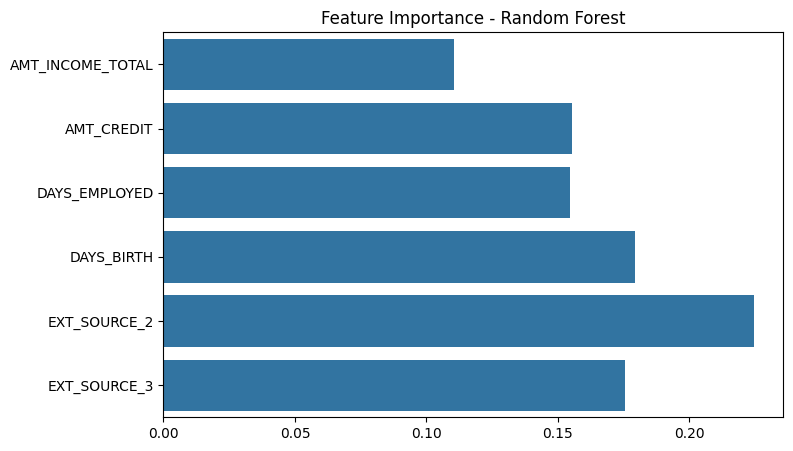

In [54]:
# Random Forest

rf = RandomForestClassifier()
rf.fit(X_train_scaled, y_train)
importances = rf.feature_importances_

plt.figure(figsize=(8,5))
sns.barplot(x=importances, y=features)
plt.title("Feature Importance - Random Forest")
plt.show()

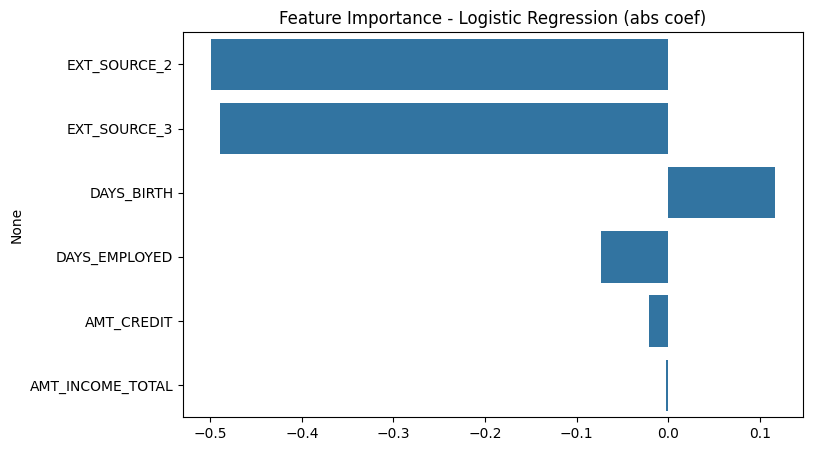

In [55]:
# Lofistic Regression
# Feature Importance - Logistic Regression
coef = best_lr.coef_[0]
feature_importance_lr = pd.Series(coef, index=features).sort_values(key=abs, ascending=False)

plt.figure(figsize=(8,5))
sns.barplot(x=feature_importance_lr.values, y=feature_importance_lr.index)
plt.title("Feature Importance - Logistic Regression (abs coef)")
plt.show()


# Permutation Importance

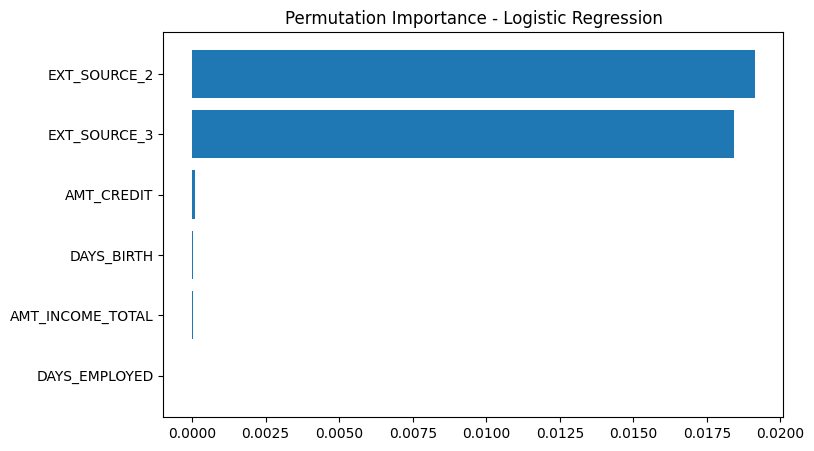

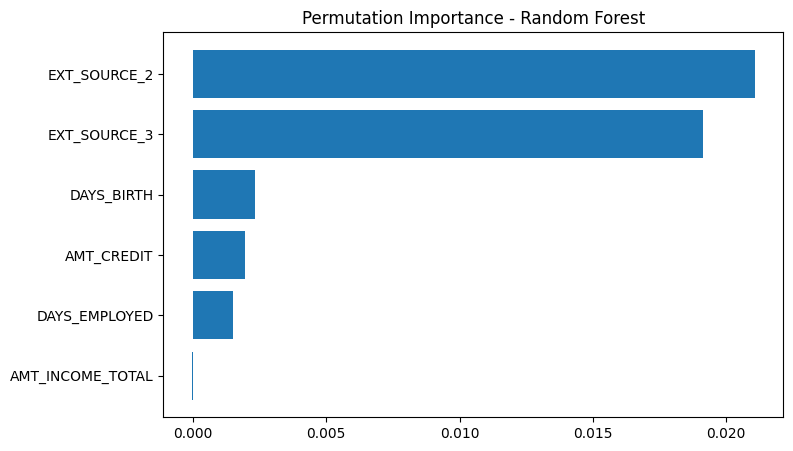

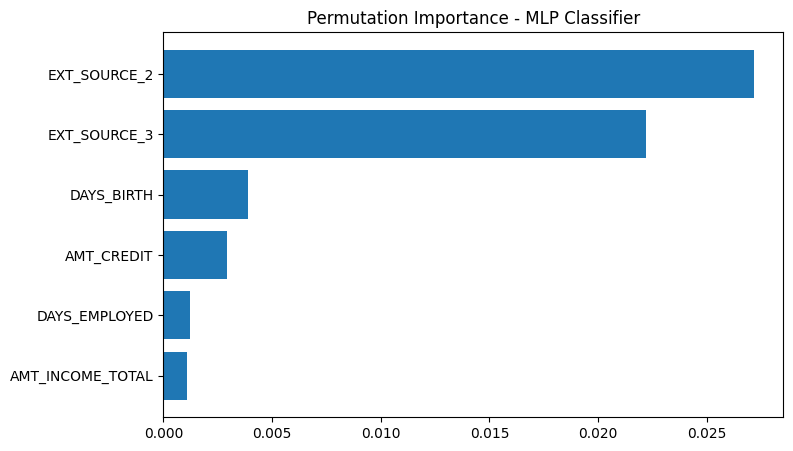

In [56]:
# 1. Permutation Importance - Logistic Regression
from sklearn.inspection import permutation_importance

result_lr = permutation_importance(best_lr, X_test_scaled, y_test, n_repeats=10, random_state=42)

sorted_idx = result_lr.importances_mean.argsort()[::-1]
plt.figure(figsize=(8,5))
plt.barh([features[i] for i in sorted_idx], result_lr.importances_mean[sorted_idx])
plt.title("Permutation Importance - Logistic Regression")
plt.gca().invert_yaxis()
plt.show()

# 2. Permutation Importance - Random Forest
result_rf = permutation_importance(best_rf, X_test_scaled, y_test, n_repeats=10, random_state=42)

sorted_idx = result_rf.importances_mean.argsort()[::-1]
plt.figure(figsize=(8,5))
plt.barh([features[i] for i in sorted_idx], result_rf.importances_mean[sorted_idx])
plt.title("Permutation Importance - Random Forest")
plt.gca().invert_yaxis()
plt.show()

# 3. Permutation Importance - MLP Classifier
result_mlp = permutation_importance(best_mlp, X_test_scaled, y_test, n_repeats=10, random_state=42)

sorted_idx = result_mlp.importances_mean.argsort()[::-1]
plt.figure(figsize=(8,5))
plt.barh([features[i] for i in sorted_idx], result_mlp.importances_mean[sorted_idx])
plt.title("Permutation Importance - MLP Classifier")
plt.gca().invert_yaxis()
plt.show()


100%|===================| 39716/39720 [36:30<00:00]       

<Figure size 640x480 with 0 Axes>

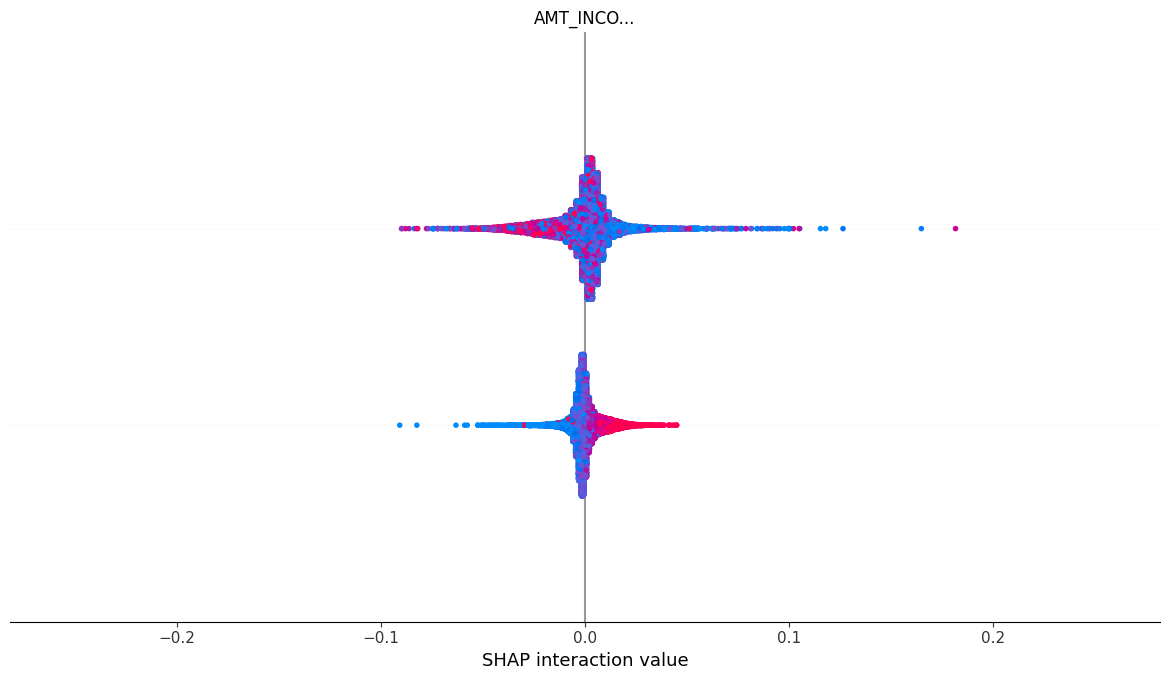

In [57]:
# Shap
import shap

explainer = shap.Explainer(best_rf, X_train_scaled)
shap_values = explainer(X_test_scaled)

shap.summary_plot(shap_values, features=X_test_scaled, feature_names=features)

# Summary

In [58]:
# === MODEL SELECTION SUMMARY (AFTER TUNING) ===

from sklearn.metrics import accuracy_score, roc_auc_score
import pandas as pd

# Dimana sebelumnya sudah punya model hasil tuning:
# best_lr, best_rf, best_dt, best_mlp
# Dimana model KNN dan Naive Bayes masih model biasa (misalnya knn_model, gnb_model)

model_results = []

model_objs = [
    ("Logistic Regression", best_lr),               # Hasil tuning
    ("Random Forest", best_rf),                     # Hasil tuning
    ("Decision Tree", best_dt),                     # Hasil tuning
    ("K-Nearest Neighbors", KNeighborsClassifier()),# Default (tidak tuning)
    ("Naive Bayes", GaussianNB()),                  # Default (tidak tuning)
    ("MLP Neural Network", best_mlp)                # Hasil tuning
]

# Fit ulang semua model (jika belum fit)
for name, model in model_objs:
    model.fit(X_train_scaled, y_train)

    y_pred_test = model.predict(X_test_scaled)
    y_proba_test = model.predict_proba(X_test_scaled)[:, 1] if hasattr(model, "predict_proba") else None
    roc = round(roc_auc_score(y_test, y_proba_test), 4) if y_proba_test is not None else "N/A"

    acc_train = round(model.score(X_train_scaled, y_train) * 100, 2)
    acc_test = round(accuracy_score(y_test, y_pred_test) * 100, 2)

    model_results.append([name, acc_train, acc_test, roc])

# Buat dataframe hasil
results_df = pd.DataFrame(model_results, columns=[
    "Model", "Training Accuracy (%)", "Testing Accuracy (%)", "ROC AUC"
])

# Urutkan berdasarkan performa test & ROC
results_df.sort_values(by=["Testing Accuracy (%)", "ROC AUC"], ascending=False, inplace=True)

# Tampilkan tabel
print("=== Model Evaluation Summary ===")
display(results_df)


=== Model Evaluation Summary ===


,Model,Training Accuracy (%),Testing Accuracy (%),ROC AUC
1,Random Forest,78.46,76.60,0.7285
5,MLP Neural Network,76.54,76.60,0.7235
2,Decision Tree,76.27,76.22,0.7119
0,Logistic Regression,76.20,76.17,0.7174
4,Naive Bayes,74.78,74.86,0.6818
3,K-Nearest Neighbors,80.42,72.95,0.6389


# Insights & Recommendations

## 🔍 Insights
Fitur-fitur terpenting yang memengaruhi risiko gagal bayar berdasarkan model antara lain:

EXT_SOURCE_3 (skor eksternal),

DAYS_EMPLOYED (lama bekerja),

DAYS_BIRTH (usia peminjam).

Calon nasabah dengan usia muda, riwayat pekerjaan tidak stabil, dan skor eksternal rendah cenderung memiliki risiko gagal bayar lebih tinggi.

Model Random Forest memberikan kinerja terbaik dengan AUC sebesar 0.7285, menunjukkan kemampuan yang baik dalam membedakan antara peminjam yang berisiko dan tidak.

## 💼 Business Recommendations
Untuk meningkatkan efektivitas proses penilaian kredit, model **Random Forest** yang terbukti memiliki performa terbaik dapat diintegrasikan sebagai bagian utama dalam sistem penilaian kredit otomatis. Model ini dapat digunakan dalam tahap pre-screening awal untuk membantu mengidentifikasi calon peminjam yang memiliki risiko gagal bayar sejak dini.

Bagi nasabah yang teridentifikasi memiliki risiko tinggi berdasarkan hasil prediksi model, perusahaan dapat menerapkan **strategi mitigasi risiko tambahan**. Misalnya, dengan meminta dokumen pendukung yang lebih lengkap, menetapkan batas pinjaman yang lebih konservatif, atau menawarkan produk kredit dengan jangka waktu yang lebih singkat guna mengurangi eksposur risiko.

Selain itu, hasil analisis menunjukkan bahwa nasabah berusia muda dengan skor eksternal rendah merupakan segmen dengan potensi risiko tinggi. Oleh karena itu, **strategi komunikasi yang lebih personal** serta **program edukasi finansial** yang ditargetkan pada kelompok ini dapat membantu memperbaiki kelayakan kredit mereka di masa depan.

Agar model tetap relevan dan akurat seiring waktu, sangat disarankan untuk melakukan **evaluasi berkala terhadap performa model** serta memperbarui data pelatihan secara rutin. Hal ini penting mengingat dinamika perilaku finansial dan kondisi ekonomi dapat berubah, yang pada akhirnya akan memengaruhi pola risiko peminjam.

## 🔢 Model Terbaik
Berdasarkan evaluasi terhadap beberapa algoritma klasifikasi, model Random Forest menunjukkan performa terbaik dengan rincian sebagai berikut:

Training Accuracy: 78.46%

Testing Accuracy: 76.60%

ROC AUC: 0.7285

Model ini dipilih karena memberikan keseimbangan yang baik antara akurasi dan kemampuan dalam membedakan kelas (AUC), serta tidak mengalami overfitting yang signifikan dibandingkan model lain seperti K-Nearest Neighbors yang memiliki gap akurasi cukup besar antara data latih dan data uji.
